In [1]:
import keras
from keras import backend as K

In [2]:
import random
import numpy as np

from keras.datasets import mnist
from keras.layers import Conv2D, Activation,AveragePooling2D,MaxPooling2D
from keras.optimizers import RMSprop
from keras.layers import Input, Flatten, Dense, Dropout,Flatten, Lambda
from keras.models import Model
from __future__ import absolute_import
from __future__ import print_function

In [3]:
num_classes=10
epochs=30

In [4]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def euclidean_distance_reshape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def euclidean_distance(vectors):
  #print("y:{0}".format(y))
  vectors_x,vectors_y = vectors
  sum_square = K.sum(K.square(vectors_x-vectors_y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))



In [5]:
import copy
def data_preprocessing(imgs, labels):
  #imgs = copy.copy(imgss.tolist())
  #labels = copy.copy(labelss.tolist())
  print("Before len(newimgs):{}, len(labels):{}".format(len(imgs), len(labels)))
  imglen = len(imgs)
  #imglen = 100
  countp = 0
  #x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
  for i in range(imglen):
    tmpa = random.randint(0, 100)
    if tmpa < 50: 
      countp += 1
      angle = random.randint(0,4)
      newimg = np.rot90(imgs[i], angle)
      #print(newimg.shape)
      #print(newimg)
      newlabel = labels[i]
      #imgs = np.concatenate((imgs,np.array([newimg])),axis=0)
      imgs = np.concatenate((imgs,[newimg]),axis=0)
      labels = np.append(labels,newlabel)
         
    tmpb = random.randint(0,100)
    if tmpb < 50:
    #else:
      countp += 1
      newimg = np.fliplr(imgs[i])
      newlabel = labels[i]
      imgs = np.concatenate((imgs,[newimg]),axis=0)
      labels = np.append(labels,newlabel)
      #print("Suc")
      #newimgs.append(newimg)
      #newlabels.append(newlabel)
    
  #print("After len(newimgs):{}, len(newlabels):{}".format(len(newimgs), len(newlabels)))

  #newimgs = np.array(newimgs)
  #newlabels = np.array(newlabels)
  #imgs += newimgs
  #labels += newlabels
  #print("Type!!!", type(imgs), type(labels))
  #print("After len(imgs):{}, len(labels):{}".format(len(imgs), len(labels)))
  print("After len(imgs):{}, len(labels):{} ++++Should have {} more imgs".format(len(imgs), len(labels), countp))
  return imgs, np.array(labels)
    

In [ ]:
backup #Not usedful
def data_preprocessing(imgs, labels):
  print("Before len(newimgs):{}, len(labels):{}".format(len(imgs), len(labels)))
  newimgs = []
  newlabels = []
  imglen = len(imgs)
  imglen = 100
  countp = 0
  for i in range(imglen):
    tmpa = random.randint(0, 100)
    if tmpa < 50: 
      countp += 1
      angle = random.randint(0,4)
      newimg = np.rot90(imgs[i], angle)
      print("type of new img", newimg, newimg.tolist())
      newlabel = labels[i]
      #print(type(imgs))
      #np.append(imgs,newimg)
      #np.append(labels,newlabel)
      np.concatenate((imgs, np.array(newimg)))
      np.concatenate((labels, np.array(newlabel)))
      #print("Suc")
      #newimgs.append(newimg)
      #newlabels.append(newlabel)
    tmpb = random.randint(0,100)
    if tmpb < 50:
      countp += 1
      newimg = np.fliplr(imgs[i])
      print("type of new img", newimg, newimg.tolist())
      newlabel = labels[i]
      np.concatenate((imgs, np.array(newimg)))
      np.concatenate((labels, np.array(newlabel)))
      #np.append(imgs,newimg)
      #np.append(labels,newlabel)
      # print("Suc")
      #newimgs.append(newimg)
      #newlabels.append(newlabel)
  #print("After len(newimgs):{}, len(newlabels):{}".format(len(newimgs), len(newlabels)))

  #newimgs = np.array(newimgs)
  #newlabels = np.array(newlabels)
  #imgs += newimgs
  #labels += newlabels
    
  print("After len(imgs):{}, len(labels):{} ++++Should have {} more imgs".format(len(imgs), len(labels), countp))
  return imgs, labels
    
    
    

NameError: ignored

In [6]:
def create_pairs(x, digit_indexs):
  pairs = []
  labels = []
  imglabels = []
  
  #Get the minimum number of images with the same labels
  n=min([len(digit_indexs[d]) for d in range(num_classes)]) -1
  print("min n:{}++++".format(n))
  
  #Create pairs of images
  for d in range(num_classes):
    #n=len(digit_indexs[d])
    #print("n:{}".format(n))
    for i in range(n):
      z1, z2 = digit_indexs[d][i], digit_indexs[d][i+1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, num_classes)
      dn = (d + inc) % num_classes
      imglabels.append([z1,z2])

      itemp = random.randrange(0, n)
      z1, z2 = digit_indexs[d][itemp], digit_indexs[dn][itemp]  
      pairs += [[x[z1], x[z2]]]
      labels += [1,0]
      imglabels.append([z1,z2])

    #print("Create_pairs, d:{},i:{}".format(d,i))
  return np.array(pairs), np.array(labels), np.array(imglabels)

In [7]:
def create_base_net(input_shape):
  
  input = Input(shape = input_shape)
  x = Conv2D(32, (3,3), activation = 'relu')(input)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Conv2D(64, (3,3), activation = 'tanh')(x)
  x = MaxPooling2D(pool_size = (2,2))(x)
  x = Dropout(0.25)(x)
  x = Flatten()(x)
  x = Dense(128, activation = 'tanh')(x)
  x = Dropout(0.5)(x)
  x = Dense(64,activation = 'tanh')(x)
  x = Dropout(0.5)(x)
  x = Dense(10,activation = 'tanh')(x)
  model = Model(input, x)
  model.summary()
  
  return model

In [8]:
def compute_accuracy(y_true, y_pred, imglabels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    confusionimgs = []
    #labelpos = imglabels.ravel()
    print(imglabels.shape)
    pred = y_pred.ravel() < 0.5
    '''
    print("pred.shape:{}, y_true.shape:{}".format(pred.shape, y_true.shape))
    flag = 0
    print("pred[0]:{},y_true[0]:{}".format(pred[0],y_true[0]))
    for i in range(len(pred)):
      if(pred[i] != y_true[i]):
        flag += 1
        print("pred[{}]:{},y_true[i]:{}".format(imglabels[i],pred[i],y_true[i]))
        print("imglabels[i][0]:{}, imglabels[i][1]:{}".format(imglabels[i][0],imglabels[i][1]))
        if flag > 10:
          break
    '''
    for i in range(len(pred)):
      if(pred[i] != y_true[i]):
        #if(i%2 == 1):
        confusionimgs += [imglabels[i][0], imglabels[i][1]]
        #else:
        #  confusionimgs += [imglabels[i-1], imglabels[i]]
    #for i in range(10):
    #  print("pred:{}".format(pred))
    return np.mean(pred == y_true), np.array(confusionimgs)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [9]:
import numpy
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(type(x_train))

print("before data_preprocessing len(x_train):{}, len(y_train):{}, len(x_test):{}, len(y_test):{}".format(len(x_train), len(y_train), len(x_test), len(y_test)))
x_train, y_train = data_preprocessing(x_train,y_train)
x_test, y_test = data_preprocessing(x_test, y_test)

print("After data_preprocessing  len(x_train):{}, len(y_train):{}, len(x_test):{}, len(y_test):{}".format(len(x_train), len(y_train), len(x_test), len(y_test)))
# x_train = numpy.asarray(x_train[-2])
#print(x_train[0] == x_train[-2])
#for i in x_train:
#  print(i.shape)
print(type(x_train[0]))
#print("y_train[0]",y_train[0])
#print("y_train",y_train)
#x_train = copy.copy(x_train[0])
#x_test = copy.copy(x_test[0])
#x_train = x_train[-2]
x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# input_shape = (1, 28, 28)
#print(x_train.shape)
#print(x_test.shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

input_shape = x_train.shape[1:]
input_shape = (28, 28, 1)
print(x_train[0].shape)
#rotate_img(x_train[0], 90)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
<class 'numpy.ndarray'>
before data_preprocessing len(x_train):60000, len(y_train):60000, len(x_test):10000, len(y_test):10000
Before len(newimgs):60000, len(labels):60000
After len(imgs):119461, len(labels):119461 ++++Should have 59461 more imgs
Before len(newimgs):10000, len(labels):10000
After len(imgs):19831, len(labels):19831 ++++Should have 9831 more imgs
After data_preprocessing  len(x_train):119461, len(y_train):119461, len(x_test):19831, len(y_test):19831
<class 'numpy.ndarray'>
(28, 28, 1)


In [10]:

print("New len(x_train):{},len(x_test):{}".format(len(x_train),len(x_test)))
# create training+test positive and negative pairs 
digit_indexs = [np.where(y_train == i)[0] for i in range(num_classes)]
train_pairs, train_y, train_pairlabels = create_pairs(x_train, digit_indexs)

digit_indexs = [np.where(y_test == i)[0] for i in range(num_classes)]
test_pairs, test_y, test_pairlabels = create_pairs(x_test, digit_indexs)
print("train_pairs:{0}, test_pairs:{1}".format(len(train_pairs),len(test_pairs)))
print("train_pairlabels:{}, test_pairlabels:{}".format(len(train_pairlabels), len(test_pairlabels)))
print(test_pairlabels)

# network definition
base_network = create_base_net(input_shape)

New len(x_train):119461,len(x_test):19831
min n:10922++++
min n:1784++++
train_pairs:218440, test_pairs:35680
train_pairlabels:218440, test_pairlabels:35680
[[    3    10]
 [17295 17728]
 [   10    13]
 ...
 [ 5050  5712]
 [17507 17536]
 [17419 19663]]
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 64)          0         
______

In [11]:
from collections import Counter
print("train_pairs shape:{0}, train_y:{1}".format(train_pairs.shape, Counter(train_y)))
print("test_pairs shape:{0}, test_y:{1}".format(test_pairs.shape, Counter(test_y)))

train_pairs shape:(218440, 2, 28, 28, 1), train_y:Counter({1: 109220, 0: 109220})
test_pairs shape:(35680, 2, 28, 28, 1), test_y:Counter({1: 17840, 0: 17840})


In [12]:
input1 = Input(shape=input_shape)
input2 = Input(shape=input_shape)

processed_a = base_network(input1)
processed_b = base_network(input2)

distance = Lambda(euclidean_distance,
                  output_shape=euclidean_distance_reshape)([processed_a, processed_b])

#print("distance:{0}".format(distance))
model = Model([input1, input2], distance)

In [13]:
rms = RMSprop()
print(train_y)
train_y = train_y.astype('float32')
test_y = test_y.astype('float32')
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_y))

[1 0 1 ... 0 1 0]
Epoch 1/30
1707/1707 [==============================] - 27s 6ms/step - loss: 0.1925 - accuracy: 0.7123 - val_loss: 0.1146 - val_accuracy: 0.8484
Epoch 2/30
1707/1707 [==============================] - 10s 6ms/step - loss: 0.1360 - accuracy: 0.8192 - val_loss: 0.1020 - val_accuracy: 0.8763
Epoch 3/30
1707/1707 [==============================] - 10s 6ms/step - loss: 0.1199 - accuracy: 0.8511 - val_loss: 0.0814 - val_accuracy: 0.9036
Epoch 4/30
1707/1707 [==============================] - 10s 6ms/step - loss: 0.1047 - accuracy: 0.8753 - val_loss: 0.0845 - val_accuracy: 0.8997
Epoch 5/30
1707/1707 [==============================] - 10s 6ms/step - loss: 0.0980 - accuracy: 0.8850 - val_loss: 0.0720 - val_accuracy: 0.9141
Epoch 6/30
1707/1707 [==============================] - 10s 6ms/step - loss: 0.0944 - accuracy: 0.8924 - val_loss: 0.0677 - val_accuracy: 0.9144
Epoch 7/30
1707/1707 [==============================] - 10s 6ms/step - loss: 0.0914 - accuracy: 0.8959 - val_los

In [14]:
# plot the confusion imgs
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

def plot_confusion_imgs(imgs, y_imgs, img_axis):
  number_of_items = 600
  matrixconfusion = defaultdict(int)
  print(len(y_imgs))
  print("img_axis",len(img_axis))
  for i in range(len(img_axis)):
    if(i%2 == 0 and i<len(y_imgs)):
      matrixconfusion[y_imgs[img_axis[i+1]]] += 1
    elif(i%2 == 1 and i+1<len(y_imgs)):
      matrixconfusion[y_imgs[img_axis[i-1]]] += 1
    matrixconfusion[y_imgs[img_axis[i]]] += 1
  print(Counter(matrixconfusion))
  for item in range(580, number_of_items, 2):
    
    print("img_axis[item]:{}, y label:[{},{}]".format(img_axis[item],y_imgs[img_axis[item]],y_imgs[img_axis[item+1]]))

  

  plt.figure(figsize=(400, 300))
  for item in range(580, number_of_items, 2):
      #print("img_axis[item]:{}".format(img_axis[item]))
      display = plt.subplot(1, number_of_items,item+1)
      im = tf.keras.preprocessing.image.array_to_img(imgs[img_axis[item]], data_format=None, scale=True,dtype=None)
      plt.imshow(im, cmap="gray")
      display.get_xaxis().set_visible(False)
      display.get_yaxis().set_visible(False)

  plt.show()

  plt.figure(figsize=(400, 300))
  for item in range(581, number_of_items, 2):
      #print("img_axis[item]:{}".format(img_axis[item]))
      display = plt.subplot(1, number_of_items,item+1)
      im = tf.keras.preprocessing.image.array_to_img(imgs[img_axis[item]], data_format=None, scale=True,dtype=None)
      plt.imshow(im, cmap="gray")
      display.get_xaxis().set_visible(False)
      display.get_yaxis().set_visible(False)

  plt.show()


train_pairs.shape:(218440, 2, 28, 28, 1)
(218440, 2)
(35680, 2)
Accuracy of training: 96.02%
Accuracy of testing: 94.16%
train_confusion:17398,test_confusion:4166
[  1502   1512   1512 ... 109554 109554 109567]
119461
img_axis 17398
Counter({5: 7400, 3: 6234, 6: 5320, 8: 4410, 2: 3828, 9: 2644, 7: 2552, 4: 992, 0: 754, 1: 662})
img_axis[item]:68661, y label:[1,1]
img_axis[item]:68792, y label:[1,1]
img_axis[item]:68793, y label:[1,1]
img_axis[item]:47672, y label:[1,5]
img_axis[item]:69912, y label:[1,1]
img_axis[item]:69919, y label:[1,1]
img_axis[item]:70048, y label:[1,1]
img_axis[item]:70070, y label:[1,1]
img_axis[item]:70124, y label:[1,1]
img_axis[item]:70131, y label:[1,1]


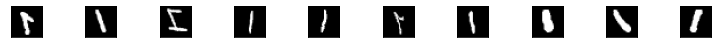

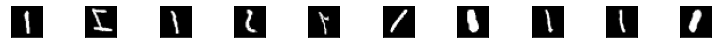

In [15]:
# compute final accuracy on training and test sets
print("train_pairs.shape:{}".format(train_pairs.shape))
y_predict = model.predict([train_pairs[:, 0], train_pairs[:, 1]])
train_acc, train_confusion = compute_accuracy(train_y, y_predict, train_pairlabels)
y_predict = model.predict([test_pairs[:, 0], test_pairs[:, 1]])
test_acc, test_confusion = compute_accuracy(test_y, y_predict, test_pairlabels)
#print(test_confusion)

print('Accuracy of training: %0.2f%%' % (100 * train_acc))
print('Accuracy of testing: %0.2f%%' % (100 * test_acc))
print("train_confusion:{},test_confusion:{}".format(len(train_confusion), len(test_confusion)))
print(train_confusion)
plot_confusion_imgs(x_train, y_train, train_confusion)

In [ ]:
'''Crash
import matplotlib.pyplot as plt
from PIL import Image
number_of_items = 1020
import tensorflow as tf

im = tf.keras.preprocessing.image.array_to_img(
    train_pairs[1,0],
    data_format=None,
    scale=True,
    dtype=None
)

plt.figure(figsize=(500, 500))
for item in range(1000, number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( train_pairs[item,0], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)

    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( train_pairs[item,1], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()


plt.figure(figsize=(500, 500))
for item in range(1000, number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( train_pairs[item,1], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

for i in range(1000, number_of_items):
  print(y_pred[i])
plt.figure(figsize=(20, 2))
plt.imshow(im, cmap="gray")
plt.show()
'''

'Crash\nimport matplotlib.pyplot as plt\nfrom PIL import Image\nnumber_of_items = 1020\nimport tensorflow as tf\n\nim = tf.keras.preprocessing.image.array_to_img(\n    train_pairs[1,0],\n    data_format=None,\n    scale=True,\n    dtype=None\n)\n\nplt.figure(figsize=(500, 500))\nfor item in range(1000, number_of_items):\n    display = plt.subplot(1, number_of_items,item+1)\n    im = tf.keras.preprocessing.image.array_to_img( train_pairs[item,0], data_format=None, scale=True,dtype=None)\n    plt.imshow(im, cmap="gray")\n    display.get_xaxis().set_visible(False)\n    display.get_yaxis().set_visible(False)\n\n    display = plt.subplot(1, number_of_items,item+1)\n    im = tf.keras.preprocessing.image.array_to_img( train_pairs[item,1], data_format=None, scale=True,dtype=None)\n    plt.imshow(im, cmap="gray")\n    display.get_xaxis().set_visible(False)\n    display.get_yaxis().set_visible(False)\nplt.show()\n\n\nplt.figure(figsize=(500, 500))\nfor item in range(1000, number_of_items):\n    

5
5


'\nfor item in range(100, number_of_items):\n    display = plt.subplot(1, number_of_items,item+1)\n    im = tf.keras.preprocessing.image.array_to_img( train_pairs[item,0], data_format=None, scale=True,dtype=None)\n    plt.imshow(im, cmap="gray")\n    display.get_xaxis().set_visible(False)\n    display.get_yaxis().set_visible(False)\nplt.show()\n'

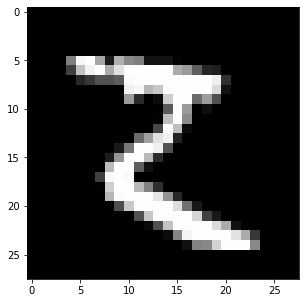

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
number_of_items = 20
import tensorflow as tf
'''
im = tf.keras.preprocessing.image.array_to_img(
    train_pairs[1,0],
    data_format=None,
    scale=True,
    dtype=None
)
'''
plt.figure(figsize=(10, 5))
im = tf.keras.preprocessing.image.array_to_img(x_train[0], data_format=None, scale=True,dtype=None)
plt.imshow(im, cmap="gray")
#display.get_xaxis().set_visible(False)
#display.get_yaxis().set_visible(False)
#plt.show()

print(y_train[0])
#newimg = rotate_img(x_train[0], 90)

newimg = np.rot90(x_train[0],2)
im_new = tf.keras.preprocessing.image.array_to_img(newimg, data_format=None, scale=True,dtype=None)
plt.imshow(im_new, cmap="gray")

newimg2 = np.fliplr(x_train[0])
im_new2 = tf.keras.preprocessing.image.array_to_img(newimg2, data_format=None, scale=True,dtype=None)
plt.imshow(im_new2, cmap="gray")
print(y_train[0])

'''
for item in range(100, number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( train_pairs[item,0], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()
'''

In [ ]:
a = [1,2,3,4,5]
def xuanzhuan(a):
  a.append("xuanzhuan")
  return a
def tiaoyue(a): 
  a.append("tiaoyue")
  return a
def bizheyan(a): 
  a.append("bizheyan")
  return a
import random
n = random.randint(0, 100)
if n < 50: 
  times = random.randint(0,3)
  print("times:{}".format(times))
  for i in range(times): 
    a = xuanzhuan(a)
  # a = xuanzhuan(a)
m = random.randint(0, 100)
if m < 50: 
  a = tiaoyue(a)
k = random.randint(0, 100)
if k < 50: 
  a = bizheyan(a) 
print(a)
#lists = []
#for one in a: 
#  tmp = operation(one)
#  lists.append(tmp)
#return lists

times:3
[1, 2, 3, 4, 5, 'xuanzhuan', 'xuanzhuan', 'xuanzhuan', 'bizheyan']


NameError: ignored

In [ ]:
a = np.array([[1,2],[3,4],5])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
c = np.array([[2,3]])

In [ ]:
b = a.tolist()
b

[[1, 2], [3, 4], 5]

In [ ]:
import numpy as np
a = np.array([1, 1], [1, 1])
b = np.array([2, 2], [2, 2])
c = np.vstack((a, b))
print(a.shape)
print(b.shape)
print(c)
print(c.shape)

TypeError: ignored

In [ ]:
a = np.array([[1,2,3],[4,5,6]])
import numpy as np
print(type(a))
print(a.shape)

<class 'numpy.ndarray'>
(2, 3)


In [ ]:
a = [[0]*10]*5
a[3][2] = 1
print(a)


[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]
